Loading in Data and custom functions

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from datetime import timedelta
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import itertools

In [2]:
# Load the Zillow dataset
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv"
ts = pd.read_csv(url)
ts.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


In [3]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

Filtering Dataset

In [7]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22467 entries, 0 to 22466
Columns: 281 entries, RegionID to 2022-09-30
dtypes: float64(273), int64(2), object(6)
memory usage: 48.2+ MB


In [8]:
# Melt the DataFrame to reshape it to long format
ts = pd.melt(ts, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'Metro', 'CountyName'], var_name='Date', value_name='HomeValue')

In [9]:
# Convert 'Date' column to datetime format
ts['Date'] = pd.to_datetime(ts['Date'], format='%Y-%m-%d', errors='coerce')
# Filter data starting from 2018
ts = ts[ts['Date'].dt.year >= 2018]
# Set 'Date' as the index
ts.set_index('Date', inplace=True)

In [10]:
# Only need NYC Metro values
ts['Metro'].value_counts()

Metro
New York-Newark-Jersey City, NY-NJ-PA           28272
Chicago-Naperville-Elgin, IL-IN-WI              20349
St. Louis, MO-IL                                14820
Washington-Arlington-Alexandria, DC-VA-MD-WV    13851
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD     13566
                                                ...  
Deming, NM                                         57
Lamesa, TX                                         57
Carson City, NV                                    57
Los Alamos, NM                                     57
Centralia, IL                                      57
Name: count, Length: 923, dtype: int64

In [11]:
# Filter data for NYC metro only
ts = ts[ts['Metro'] == 'New York-Newark-Jersey City, NY-NJ-PA']
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28272 entries, 2018-01-31 to 2022-09-30
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    28272 non-null  int64  
 1   SizeRank    28272 non-null  int64  
 2   RegionName  28272 non-null  object 
 3   RegionType  28272 non-null  object 
 4   StateName   28272 non-null  object 
 5   State       28272 non-null  object 
 6   Metro       28272 non-null  object 
 7   CountyName  28272 non-null  object 
 8   HomeValue   28116 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 2.2+ MB


In [12]:
# Discarding Nulls
ts = ts.dropna(subset=['HomeValue'])
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28116 entries, 2018-01-31 to 2022-09-30
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    28116 non-null  int64  
 1   SizeRank    28116 non-null  int64  
 2   RegionName  28116 non-null  object 
 3   RegionType  28116 non-null  object 
 4   StateName   28116 non-null  object 
 5   State       28116 non-null  object 
 6   Metro       28116 non-null  object 
 7   CountyName  28116 non-null  object 
 8   HomeValue   28116 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 2.1+ MB


In [13]:
print(ts.isnull().sum())

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
State         0
Metro         0
CountyName    0
HomeValue     0
dtype: int64


Exploratory Data Analysis

In [14]:
# Check for stationarity using your custom function
adfuller_results = get_adfuller_results(ts['HomeValue'], label='HomeValue')

# Print the ADF test results
print(adfuller_results)

           Test Statistic  # of Lags Used  # of Observations  p-value  alpha  \
HomeValue      -17.268989              50              28065      0.0   0.05   

           sig/stationary?  
HomeValue             True  


In [15]:
# Determine the number of differences needed for stationarity
n_diffs = 0  # Set to 0 since ADF test indicated stationarity
print(f'Number of Differences Needed: {n_diffs}')

Number of Differences Needed: 0


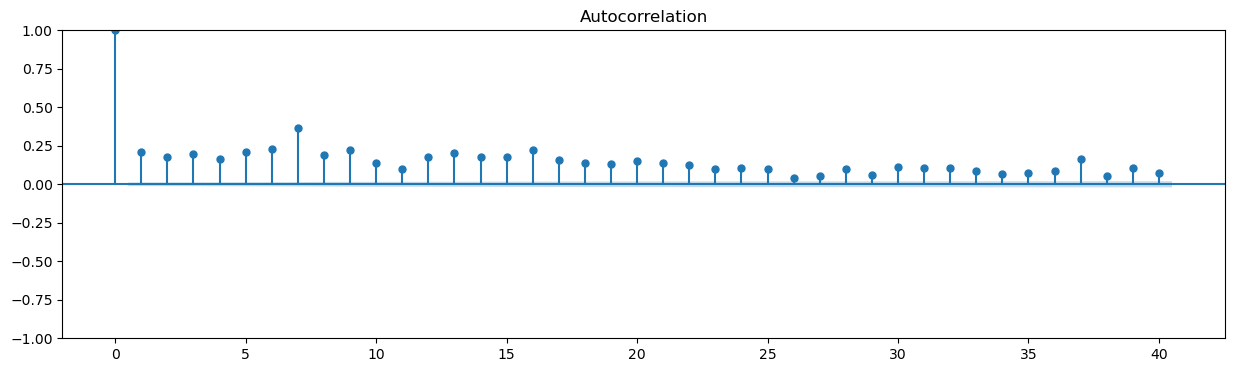

In [16]:
# Plot ACF of the original series
fig, ax = plt.subplots(figsize=(15, 4))
plot_acf(ts['HomeValue'], lags=40, ax=ax, alpha=0.05)
plt.show()

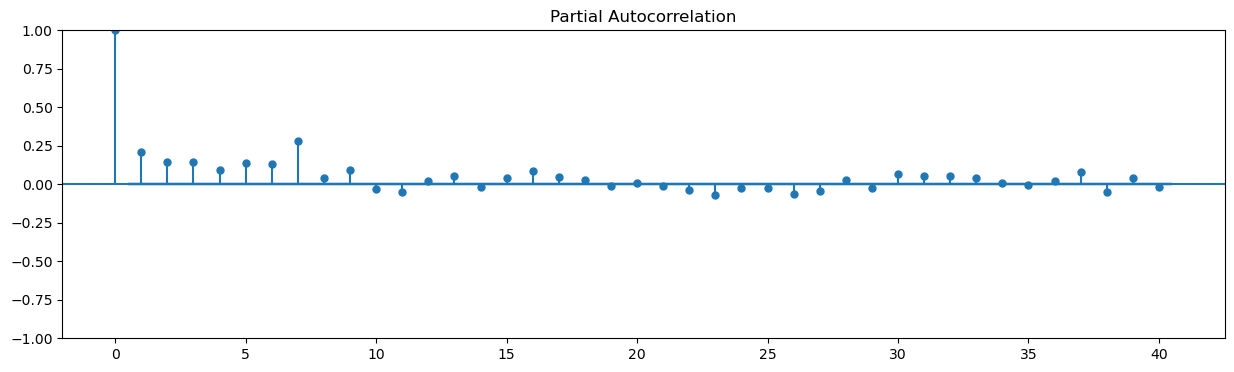

In [17]:
# Plot PACF of the original series
fig, ax = plt.subplots(figsize=(15, 4))
plot_pacf(ts['HomeValue'], lags=40, ax=ax, alpha=0.05)
plt.show()

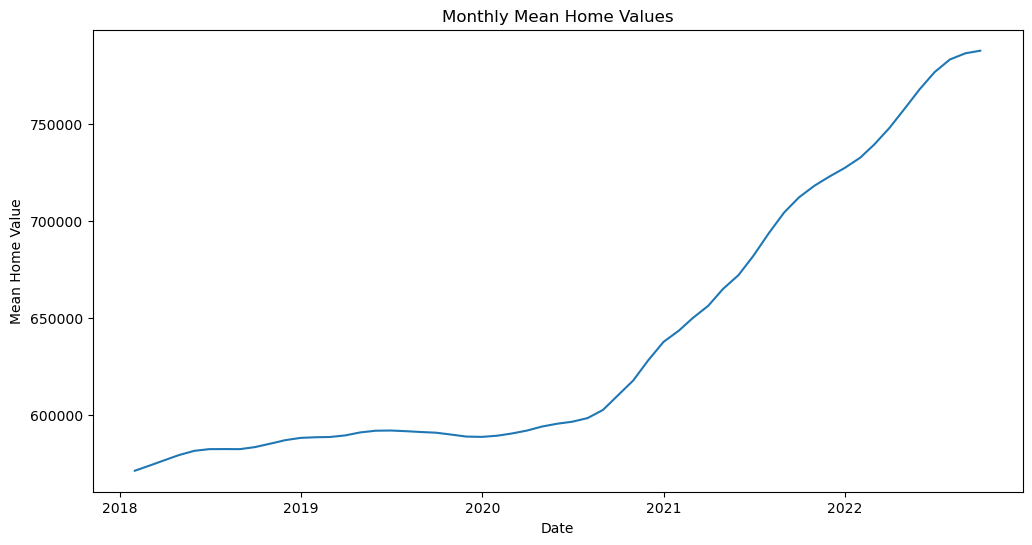

In [18]:
# Monthly Home Values Graph
monthly_mean = ts['HomeValue'].resample('M').mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_mean)
plt.title('Monthly Mean Home Values')
plt.xlabel('Date')
plt.ylabel('Mean Home Value')
plt.show()

C:\Users\James\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\James\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\James\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\James\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

AttributeError: 'PredictionResults' object has no attribute 'index'

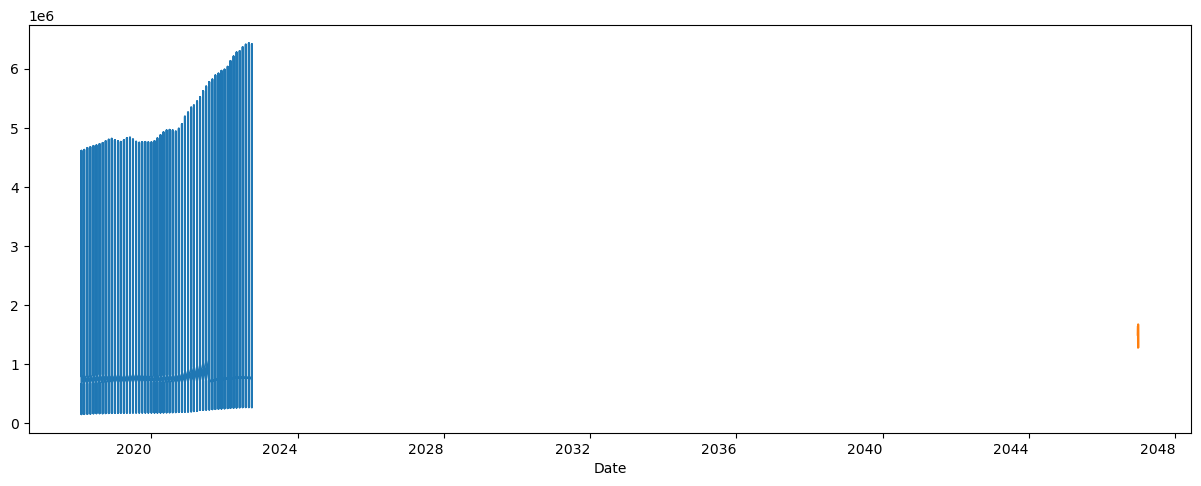

In [20]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming you've determined values for p, d, and q
p =  1
d =  0
q =  8

# Fit ARIMA model
model = ARIMA(ts['HomeValue'], order=(p, d, q))
result = model.fit()

# Make forecasts for the next 6 months
forecast_steps = 6
forecasts = result.get_forecast(steps=forecast_steps)

# Plot forecasts against the actual values
plt.figure(figsize=(15, 6))
ts['HomeValue'].plot(label='Observed Time Series')
forecasts.predicted_mean.plot(label='Forecasted Values')
plt.fill_between(forecasts.index, forecasts.conf_int()[:, 0], forecasts.conf_int()[:, 1], color='gray', alpha=0.2, label='Confidence Interval')
plt.title('ARIMA Model Forecasting')
plt.xlabel('Date')
plt.ylabel('Home Value')
plt.legend()
plt.show()

In [ ]:
get_adfuller_results(ts_home_value)

In [ ]:
# Plot ACF and PACFada
plot_acf_pacf(ts_home_value)

In [ ]:
# Determine the number of differences needed
d = ndiffs(ts_home_value)
print(f'Determined non-seasonal differences (d): {d}')

In [ ]:
# Differencing the data once
ts_diff = ts_home_value.diff().dropna()
ts_diff.plot()
# Checking for stationarity
get_adfuller_results(ts_diff)

In [ ]:
plot_acf_pacf(ts_diff);

In [ ]:
ts_home_value.info()

In [ ]:
pip install --upgrade statsmodels

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'ts' is your DataFrame with a DatetimeIndex and 'HomeValue' column
# Extract the 'HomeValue' column with non-null values
ts_home_value = ts['HomeValue'].dropna()

# Apply seasonal decomposition
decomp = seasonal_decompose(ts_home_value)

# Plot each component separately
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(decomp.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomp.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomp.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomp.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'ts' is your DataFrame with a DatetimeIndex and 'HomeValue' column
# Extract the 'HomeValue' column with non-null values
ts_home_value = ts['HomeValue'].dropna()

# Apply seasonal decomposition
decomp = seasonal_decompose(ts_home_value)
fig = decomp.plot()
fig.set_size_inches(12, 5)
fig.tight_layout()

In [ ]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts_home_value)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [ ]:
ts_home_value.index = pd.to_datetime(ts_home_value.index)
ts_home_value = ts_home_value.asfreq('M')

In [ ]:
# Aggregate values by taking the mean of duplicate timestamps
ts_home_value = ts_home_value.groupby('Date').mean()

In [ ]:
# Train-test split
train_size = int(len(ts) * 0.75)
train, test = ts['HomeValue'][:train_size], ts['HomeValue'][train_size:]

In [ ]:
# Orders for non-seasonal components
p = 1
d = 1
q = 1

# Orders for seasonal components
P = 1
D = 0
Q = 1
m = 12

# Fit SARIMA model
sarima = tsa.ARIMA(train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])


In [ ]:
p_range = range(0, 2)
d_range = range(0, 2)
q_range = range(0, 2)
P_range = range(0, 2)
D_range = range(0, 2)
Q_range = range(0, 2)
m = 12

In [ ]:
pip install pmdarima

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pmdarima import ARIMA

# Define the parameter distributions
param_dist = {
    'order': [(p, d, q) for p in p_range for d in d_range for q in q_range],
    'seasonal_order': [(P, D, Q, m) for P in P_range for D in D_range for Q in Q_range]
}

# Create a randomized search
random_search = RandomizedSearchCV(
    ARIMA(),
    param_distributions=param_dist,
    n_iter=10,  # Adjust the number of iterations
    scoring='aic',  # Use AIC as the scoring metric
    cv=5,  # Adjust the number of cross-validation folds
    verbose=1,
    n_jobs=-1
)

# Fit the randomized search
random_search.fit(train)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distributions
param_dist = {
    'order': [(p, d, q) for p in p_range for d in d_range for q in q_range],
    'seasonal_order': [(P, D, Q, m) for P in P_range for D in D_range for Q in Q_range]
}

# Create a randomized search
random_search = RandomizedSearchCV(
    pm.ARIMA(),
    param_distributions=param_dist,
    n_iter=10,  # Adjust the number of iterations
    scoring='aic',  # Use AIC as the scoring metric
    cv=5,  # Adjust the number of cross-validation folds
    verbose=1,
    n_jobs=-1
)

# Fit the randomized search
random_search.fit(train)
